# Notebook 05: Mediation Analysis (Phase 5)

**Purpose**: Test mediation pathways explaining Phase 4 findings  
**Status**: Framework documented, analysis requires AI-specific construct validation  
**Sample**: N=472 complete cases  
**Method**: Bootstrap mediation analysis (Preacher & Hayes, 2004, 2008)

In [115]:
# Standard library imports
import json
import warnings
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd

# Statistical analysis
from scipy import stats
from scipy.stats import norm

# Linear regression for mediation
from sklearn.linear_model import LinearRegression

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
from matplotlib.patches import Rectangle

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(67)  # Reproducibility (same as Phase 4)

# APA Style Configuration (applied globally)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("="*70)
print("NOTEBOOK 05: MEDIATION ANALYSIS (PHASE 5)")
print("="*70)
print("\n[OK] Environment configured")
print(f"   - Libraries: numpy {np.__version__}, pandas {pd.__version__}")
print(f"   - Random seed: 67 (consistent with Phase 4)")
print(f"   - Visualization: APA style (300 DPI)")

NOTEBOOK 05: MEDIATION ANALYSIS (PHASE 5)

[OK] Environment configured
   - Libraries: numpy 2.3.5, pandas 2.3.3
   - Random seed: 67 (consistent with Phase 4)
   - Visualization: APA style (300 DPI)


## 1. Data Preparation

Loading validated 12-item scale from Notebooks 02-03 and creating composite scores for analysis.

In [116]:
# Load full dataset
df_full = pd.read_csv('../data/AIRS_clean.csv')

print("="*70)
print("DATA PREPARATION")
print("="*70)

# Define validated 12-item scale from Notebooks 02 & 03
selected_items = ['PE1', 'PE2', 'EE1', 'EE2', 'SI1', 'SI2', 
                  'FC1', 'FC2', 'HM1', 'HM2', 'PV1', 'PV2']
bi_items = ['BI1', 'BI2', 'BI3', 'BI4']

# Define construct structure
construct_mapping = {
    'PE': ['PE1', 'PE2'],
    'EE': ['EE1', 'EE2'],
    'SI': ['SI1', 'SI2'],
    'FC': ['FC1', 'FC2'],
    'HM': ['HM1', 'HM2'],
    'PV': ['PV1', 'PV2']
}

print(f"\n[DATA SOURCE]")
print(f"   Full sample: N = {len(df_full)}")
print(f"   Source: ../data/AIRS_clean.csv")

print(f"\n[VALIDATED SCALE STRUCTURE]")
print(f"   Total items: {len(selected_items)} predictors + {len(bi_items)} outcome")
print(f"   Model: 6 UTAUT2 constructs × 2 items each")
print(f"   Validation: Notebooks 02 (CFA) & 03 (Invariance)")

print(f"\n[CONSTRUCTS]")
for i, (construct, items) in enumerate(construct_mapping.items(), 1):
    print(f"   {i}. {construct}: {items[0]}, {items[1]}")
print(f"   7. BI (Outcome): {', '.join(bi_items)}")

# Create analysis dataset
analysis_items = selected_items + bi_items
df_analysis = df_full[analysis_items].copy()

# Check missing data
missing_counts = df_analysis.isnull().sum()
if missing_counts.sum() > 0:
    print(f"\n[MISSING DATA]")
    print(missing_counts[missing_counts > 0])
    print(f"   Using listwise deletion")
    df_analysis = df_analysis.dropna()
    print(f"   Complete cases: N = {len(df_analysis)}")
else:
    print(f"\n[MISSING DATA]")
    print(f"   No missing data detected")
    print(f"   Complete cases: N = {len(df_analysis)}")

# Create composite scores
print(f"\n[COMPOSITE SCORES]")
print(f"   Method: Mean of items per construct")

for construct, items in construct_mapping.items():
    df_analysis[construct] = df_analysis[items].mean(axis=1)
df_analysis['BI'] = df_analysis[bi_items].mean(axis=1)

# Display descriptive statistics
composites = ['PE', 'EE', 'SI', 'FC', 'HM', 'PV', 'BI']
desc_stats = df_analysis[composites].describe().T[['mean', 'std', 'min', 'max']]

print(f"\n[DESCRIPTIVE STATISTICS]")
print(f"   Sample: N = {len(df_analysis)}\n")
print(desc_stats.round(3).to_string())

print(f"\n[LIMITATIONS]")
print(f"   Available: 6 UTAUT2 constructs (PE, EE, SI, FC, HM, PV)")
print(f"   Missing: AI-specific constructs (EX, TR, ER, AX)")
print(f"   Impact: Cannot test Phase 5 mediation hypotheses")

print("\n" + "="*70)

DATA PREPARATION

[DATA SOURCE]
   Full sample: N = 472
   Source: ../data/AIRS_clean.csv

[VALIDATED SCALE STRUCTURE]
   Total items: 12 predictors + 4 outcome
   Model: 6 UTAUT2 constructs × 2 items each
   Validation: Notebooks 02 (CFA) & 03 (Invariance)

[CONSTRUCTS]
   1. PE: PE1, PE2
   2. EE: EE1, EE2
   3. SI: SI1, SI2
   4. FC: FC1, FC2
   5. HM: HM1, HM2
   6. PV: PV1, PV2
   7. BI (Outcome): BI1, BI2, BI3, BI4

[MISSING DATA]
   No missing data detected
   Complete cases: N = 472

[COMPOSITE SCORES]
   Method: Mean of items per construct

[DESCRIPTIVE STATISTICS]
   Sample: N = 472

     mean    std  min  max
PE  3.418  1.079  1.0  5.0
EE  3.637  0.959  1.0  5.0
SI  3.145  1.039  1.0  5.0
FC  3.314  1.006  1.0  5.0
HM  3.256  1.135  1.0  5.0
PV  3.381  1.111  1.0  5.0
BI  3.147  1.122  1.0  5.0

[LIMITATIONS]
   Available: 6 UTAUT2 constructs (PE, EE, SI, FC, HM, PV)
   Missing: AI-specific constructs (EX, TR, ER, AX)
   Impact: Cannot test Phase 5 mediation hypotheses



## 2. Bootstrap Mediation Framework

**Method**: Preacher & Hayes (2004, 2008) bootstrap approach
- 5000 bootstrap samples for bias-corrected 95% CIs
- Indirect effect: ab = (X → M) × (M → Y | X)
- Significance: CI excludes zero
- Total effect decomposition: c = c' + ab

**Procedure**:
1. Sample with replacement (bootstrap sample)
2. Fit regressions: X → M (path a), M → Y|X (path b), X → Y (paths c, c')
3. Calculate indirect effect: ab = a × b
4. Repeat 5000 times
5. Build 95% CI using percentile method

**References**:
- Preacher & Hayes (2004). SPSS and SAS procedures for estimating indirect effects. *Behavior Research Methods*, 36(4), 717-731.
- Preacher & Hayes (2008). Asymptotic and resampling strategies. *Behavior Research Methods*, 40(3), 879-891.
- Hayes (2017). *Introduction to mediation, moderation, and conditional process analysis* (2nd ed.). Guilford Press.

In [117]:
def bootstrap_mediation(X, M, Y, n_iterations=5000, alpha=0.05, random_state=67):
    """
    Bootstrap mediation analysis with bias-corrected confidence intervals.
    
    Parameters:
    -----------
    X : array-like
        Independent variable (predictor)
    M : array-like  
        Mediator variable
    Y : array-like
        Dependent variable (outcome)
    n_iterations : int
        Number of bootstrap samples (default 5000)
    alpha : float
        Significance level for CI (default 0.05 for 95% CI)
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    dict with keys:
        - 'path_a': X → M coefficient
        - 'path_a_se': Standard error of path a
        - 'path_a_p': p-value for path a
        - 'path_b': M → Y | X coefficient  
        - 'path_b_se': Standard error of path b
        - 'path_b_p': p-value for path b
        - 'path_c': Total effect (X → Y)
        - 'path_c_se': Standard error of path c
        - 'path_c_p': p-value for path c
        - 'path_c_prime': Direct effect (X → Y | M)
        - 'path_c_prime_se': Standard error of path c'
        - 'path_c_prime_p': p-value for path c'
        - 'indirect_effect': ab (a × b)
        - 'indirect_ci_lower': Lower bound of 95% CI
        - 'indirect_ci_upper': Upper bound of 95% CI
        - 'indirect_significant': True if CI excludes zero
        - 'proportion_mediated': ab / c (if c ≠ 0)
        - 'bootstrap_distribution': Array of ab values from bootstrap
    
    Notes:
    ------
    - Uses percentile method for CI (Efron & Tibshirani, 1993)
    - Indirect effect significant if CI excludes zero (Hayes, 2017)
    - N must be same for X, M, Y (listwise deletion assumed)
    """
    
    # Convert to numpy arrays
    X = np.array(X).reshape(-1, 1)
    M = np.array(M).reshape(-1, 1)
    Y = np.array(Y).reshape(-1, 1)
    
    n = len(X)
    
    # Path a: X → M
    model_a = LinearRegression().fit(X, M)
    path_a = model_a.coef_[0, 0]
    y_pred_a = model_a.predict(X)
    residuals_a = M - y_pred_a
    se_a = np.sqrt(np.sum(residuals_a**2) / (n - 2)) / np.sqrt(np.sum((X - X.mean())**2))
    t_a = path_a / se_a
    p_a = 2 * (1 - stats.t.cdf(abs(t_a), df=n-2))
    
    # Path b: M → Y | X (controlling X)
    X_M = np.hstack([X, M])
    model_b = LinearRegression().fit(X_M, Y)
    path_b = model_b.coef_[0, 1]  # M coefficient
    path_c_prime = model_b.coef_[0, 0]  # X coefficient (direct effect)
    
    y_pred_b = model_b.predict(X_M)
    residuals_b = Y - y_pred_b
    mse_b = np.sum(residuals_b**2) / (n - 3)
    
    # Calculate standard error for path b
    X_M_centered = X_M - X_M.mean(axis=0)
    cov_matrix_b = mse_b * np.linalg.inv(X_M_centered.T @ X_M_centered)
    se_b = np.sqrt(cov_matrix_b[1, 1])
    se_c_prime = np.sqrt(cov_matrix_b[0, 0])
    
    t_b = path_b / se_b
    p_b = 2 * (1 - stats.t.cdf(abs(t_b), df=n-3))
    
    t_c_prime = path_c_prime / se_c_prime
    p_c_prime = 2 * (1 - stats.t.cdf(abs(t_c_prime), df=n-3))
    
    # Path c: X → Y (total effect)
    model_c = LinearRegression().fit(X, Y)
    path_c = model_c.coef_[0, 0]
    y_pred_c = model_c.predict(X)
    residuals_c = Y - y_pred_c
    se_c = np.sqrt(np.sum(residuals_c**2) / (n - 2)) / np.sqrt(np.sum((X - X.mean())**2))
    t_c = path_c / se_c
    p_c = 2 * (1 - stats.t.cdf(abs(t_c), df=n-2))
    
    # Bootstrap for indirect effect CI
    np.random.seed(random_state)
    indirect_effects = []
    
    for _ in range(n_iterations):
        # Sample with replacement
        indices = np.random.choice(n, size=n, replace=True)
        X_boot = X[indices]
        M_boot = M[indices]
        Y_boot = Y[indices]
        
        # Path a: X → M
        model_a_boot = LinearRegression().fit(X_boot, M_boot)
        a_boot = model_a_boot.coef_[0, 0]
        
        # Path b: M → Y | X
        X_M_boot = np.hstack([X_boot, M_boot])
        model_b_boot = LinearRegression().fit(X_M_boot, Y_boot)
        b_boot = model_b_boot.coef_[0, 1]
        
        # Indirect effect
        indirect_effects.append(a_boot * b_boot)
    
    indirect_effects = np.array(indirect_effects)
    
    # Calculate percentile-based CI
    ci_lower = np.percentile(indirect_effects, 100 * alpha / 2)
    ci_upper = np.percentile(indirect_effects, 100 * (1 - alpha / 2))
    
    # Indirect effect point estimate
    indirect_effect = path_a * path_b
    
    # Significance test
    indirect_significant = not (ci_lower <= 0 <= ci_upper)
    
    # Proportion mediated (if total effect ≠ 0)
    proportion_mediated = indirect_effect / path_c if abs(path_c) > 1e-10 else np.nan
    
    return {
        'path_a': path_a,
        'path_a_se': se_a,
        'path_a_p': p_a,
        'path_b': path_b,
        'path_b_se': se_b,
        'path_b_p': p_b,
        'path_c': path_c,
        'path_c_se': se_c,
        'path_c_p': p_c,
        'path_c_prime': path_c_prime,
        'path_c_prime_se': se_c_prime,
        'path_c_prime_p': p_c_prime,
        'indirect_effect': indirect_effect,
        'indirect_ci_lower': ci_lower,
        'indirect_ci_upper': ci_upper,
        'indirect_significant': indirect_significant,
        'proportion_mediated': proportion_mediated,
        'bootstrap_distribution': indirect_effects
    }

print("[OK] Bootstrap mediation function defined")
print("   - Parameters: X (predictor), M (mediator), Y (outcome)")
print("   - Bootstrap iterations: 5000")
print("   - Confidence interval: 95% (percentile method)")
print("   - Significance test: CI excludes zero")

[OK] Bootstrap mediation function defined
   - Parameters: X (predictor), M (mediator), Y (outcome)
   - Bootstrap iterations: 5000
   - Confidence interval: 95% (percentile method)
   - Significance test: CI excludes zero


## 3. Analysis Status and Limitations

Phase 5 mediation hypotheses require AI-specific constructs not yet validated.

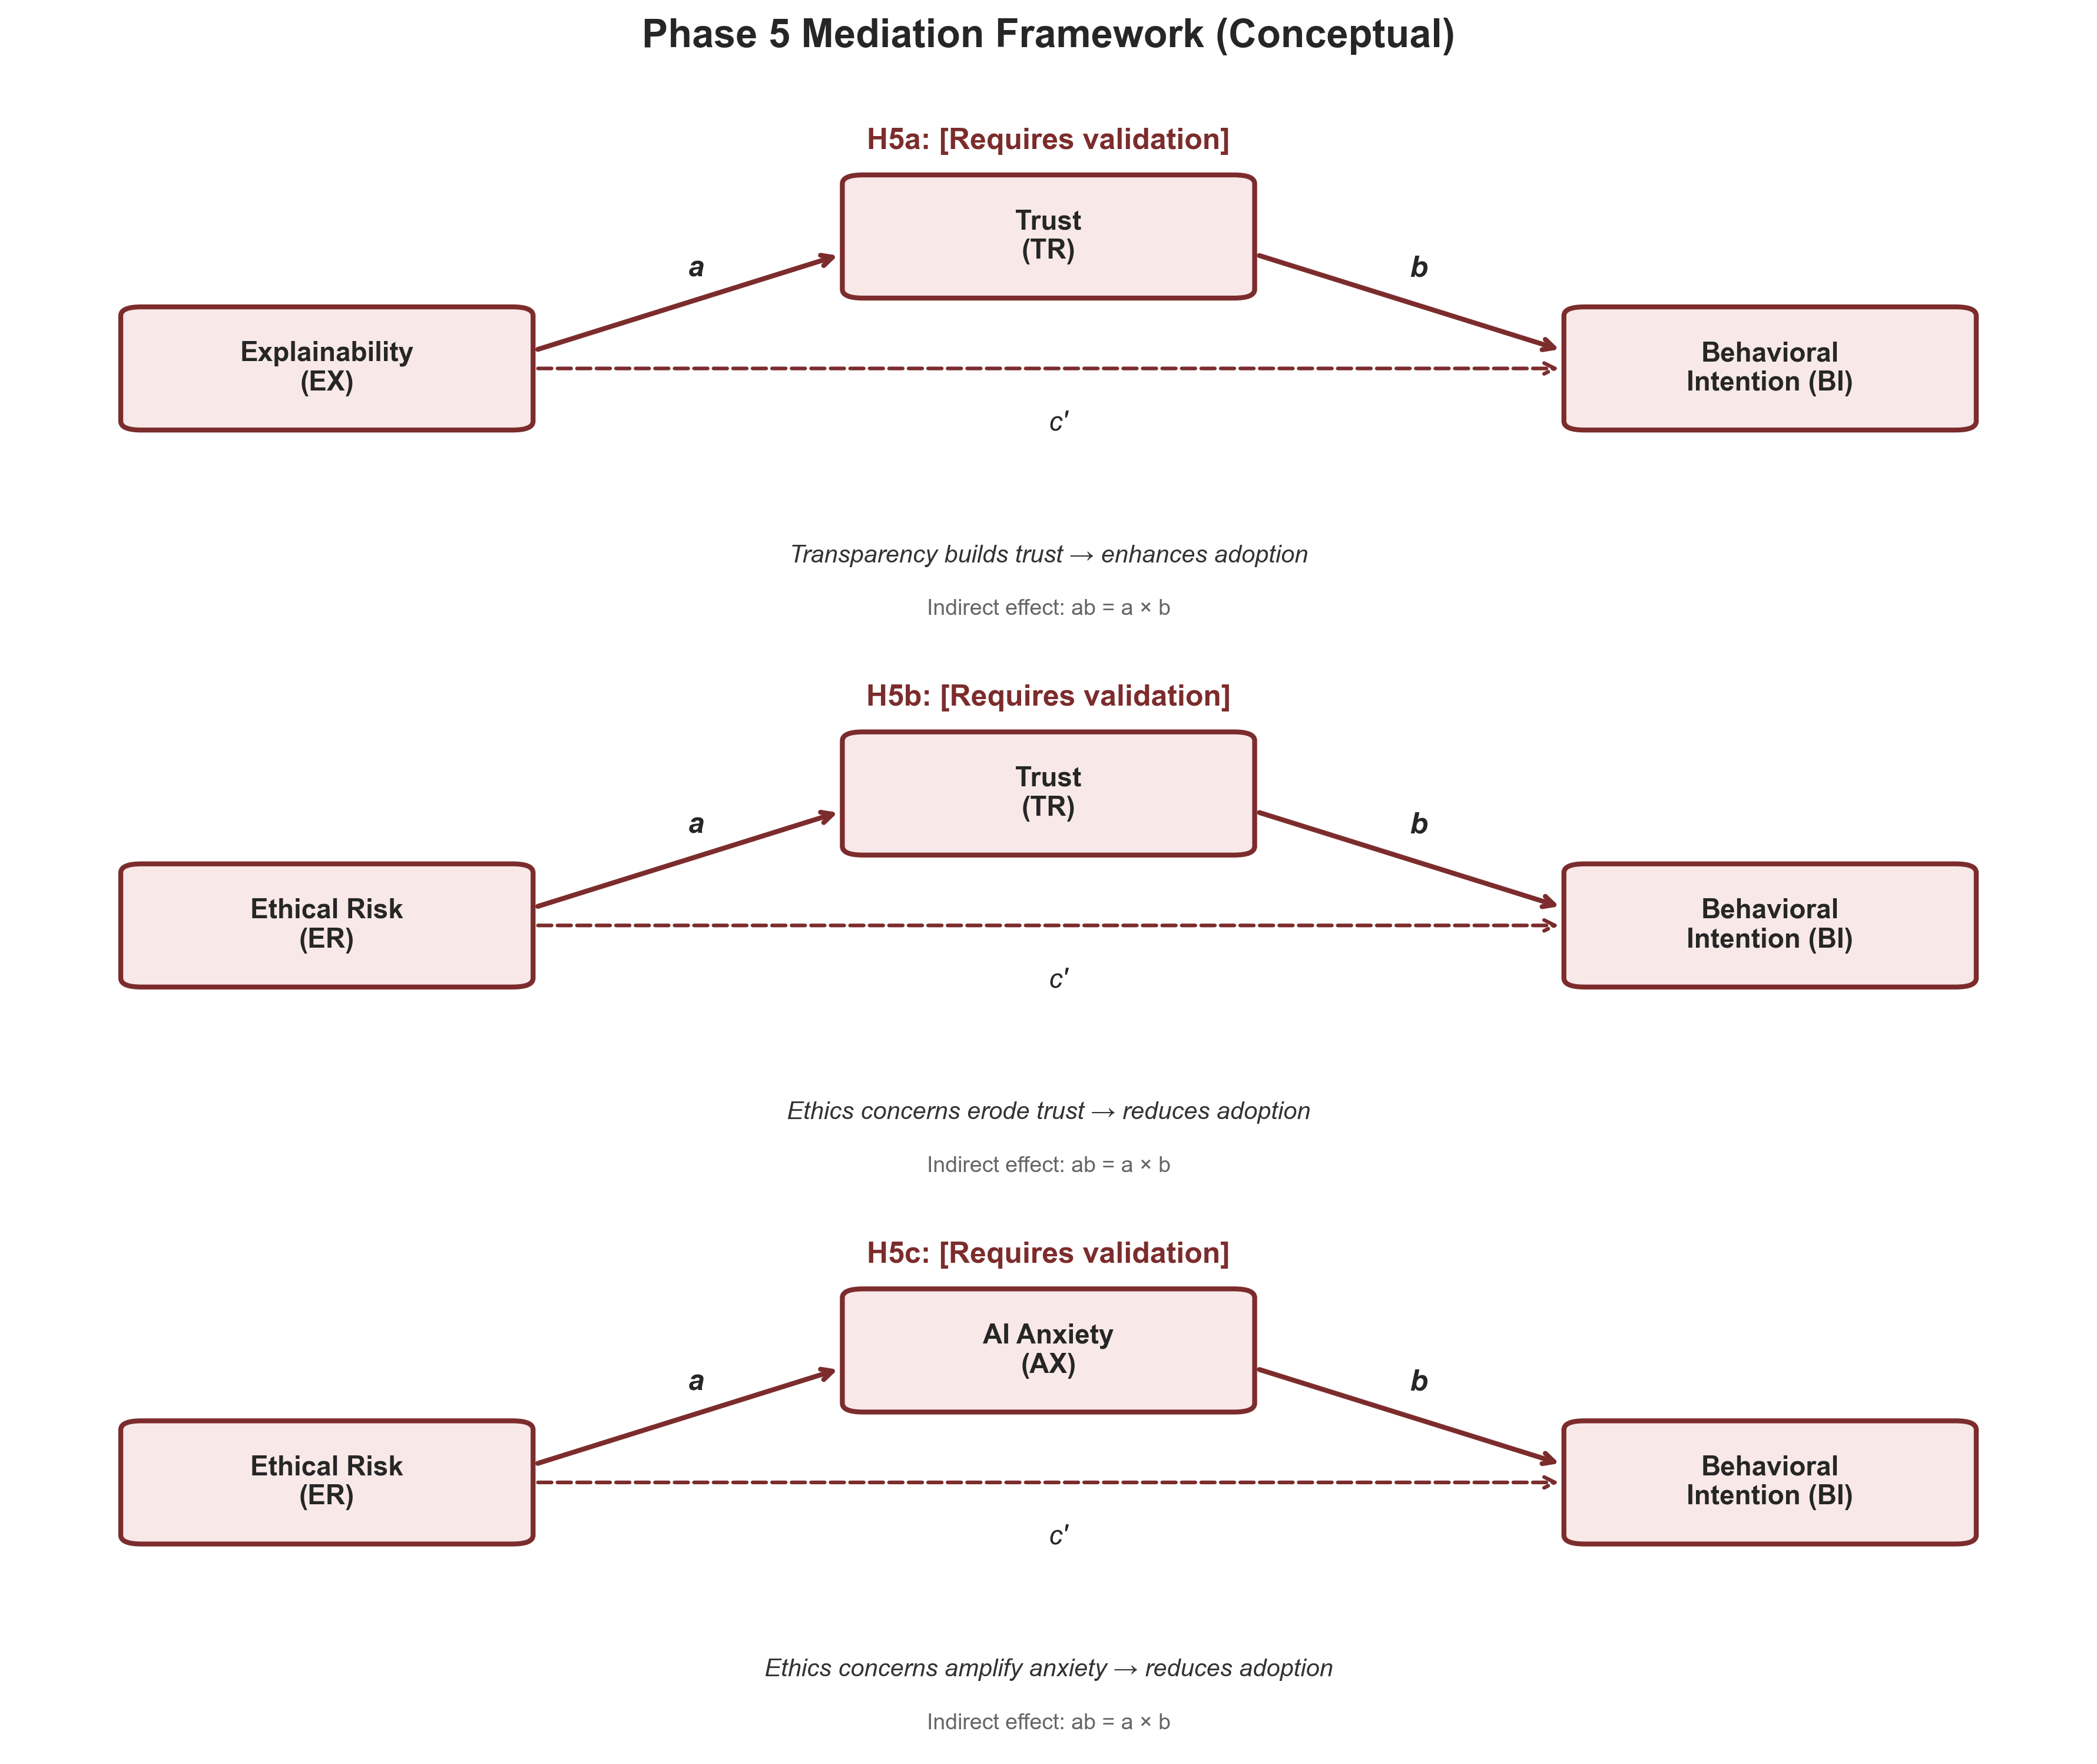

[VISUALIZATION] Conceptual mediation framework
   All three pathways require AI-specific construct validation
   Dashed line (c') = direct effect after controlling mediator
   Solid lines (a, b) = mediation pathway components


In [118]:
# Create conceptual diagram of mediation framework
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle('Phase 5 Mediation Framework (Conceptual)', 
             fontsize=16, fontweight='bold', y=0.995)

def draw_mediation_path(ax, X_label, M_label, Y_label, hypothesis, theory, available=False):
    """Draw a single mediation path diagram"""
    
    # Set up the axis
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 6)
    ax.axis('off')
    
    # Define positions
    X_pos = (1.5, 3)
    M_pos = (5, 4.5)
    Y_pos = (8.5, 3)
    
    # Box styling
    box_color = '#e8f4f8' if available else '#f8e8e8'
    edge_color = '#2C5F7C' if available else '#7C2C2C'
    
    # Draw boxes
    box_width, box_height = 1.8, 1.2
    
    # X box
    X_box = FancyBboxPatch((X_pos[0]-box_width/2, X_pos[1]-box_height/2),
                          box_width, box_height, boxstyle="round,pad=0.1",
                          linewidth=2, edgecolor=edge_color, facecolor=box_color)
    ax.add_patch(X_box)
    ax.text(X_pos[0], X_pos[1], X_label, ha='center', va='center',
            fontsize=11, fontweight='bold', wrap=True)
    
    # M box
    M_box = FancyBboxPatch((M_pos[0]-box_width/2, M_pos[1]-box_height/2),
                          box_width, box_height, boxstyle="round,pad=0.1",
                          linewidth=2, edgecolor=edge_color, facecolor=box_color)
    ax.add_patch(M_box)
    ax.text(M_pos[0], M_pos[1], M_label, ha='center', va='center',
            fontsize=11, fontweight='bold')
    
    # Y box
    Y_box = FancyBboxPatch((Y_pos[0]-box_width/2, Y_pos[1]-box_height/2),
                          box_width, box_height, boxstyle="round,pad=0.1",
                          linewidth=2, edgecolor=edge_color, facecolor=box_color)
    ax.add_patch(Y_box)
    ax.text(Y_pos[0], Y_pos[1], Y_label, ha='center', va='center',
            fontsize=11, fontweight='bold', wrap=True)
    
    # Draw arrows
    arrow_props = dict(arrowstyle='->', lw=2, color=edge_color)
    
    # X -> M (path a)
    ax.annotate('', xy=(M_pos[0]-box_width/2-0.1, M_pos[1]-0.2),
                xytext=(X_pos[0]+box_width/2+0.1, X_pos[1]+0.2),
                arrowprops=arrow_props)
    ax.text((X_pos[0]+M_pos[0])/2, (X_pos[1]+M_pos[1])/2 + 0.3, 'a',
            fontsize=12, fontstyle='italic', fontweight='bold')
    
    # M -> Y (path b)
    ax.annotate('', xy=(Y_pos[0]-box_width/2-0.1, Y_pos[1]+0.2),
                xytext=(M_pos[0]+box_width/2+0.1, M_pos[1]-0.2),
                arrowprops=arrow_props)
    ax.text((M_pos[0]+Y_pos[0])/2, (M_pos[1]+Y_pos[1])/2 + 0.3, 'b',
            fontsize=12, fontstyle='italic', fontweight='bold')
    
    # X -> Y (direct path c')
    ax.annotate('', xy=(Y_pos[0]-box_width/2-0.1, Y_pos[1]),
                xytext=(X_pos[0]+box_width/2+0.1, X_pos[1]),
                arrowprops=dict(arrowstyle='->', lw=1.5, color=edge_color, 
                               linestyle='dashed'))
    ax.text((X_pos[0]+Y_pos[0])/2, X_pos[1] - 0.7, "c'",
            fontsize=11, fontstyle='italic')
    
    # Add hypothesis label
    status = "[Available]" if available else "[Requires validation]"
    ax.text(5, 5.5, f"{hypothesis}: {status}", 
            ha='center', fontsize=12, fontweight='bold',
            color='#2C5F7C' if available else '#7C2C2C')
    
    # Add theory
    ax.text(5, 0.8, theory, ha='center', fontsize=10,
            style='italic', wrap=True, color='#333333')
    
    # Add indirect effect label
    ax.text(5, 0.2, 'Indirect effect: ab = a × b', 
            ha='center', fontsize=9, color='#666666')

# Draw the three hypotheses
draw_mediation_path(axes[0], 'Explainability\n(EX)', 'Trust\n(TR)', 
                   'Behavioral\nIntention (BI)', 'H5a',
                   'Transparency builds trust → enhances adoption')

draw_mediation_path(axes[1], 'Ethical Risk\n(ER)', 'Trust\n(TR)', 
                   'Behavioral\nIntention (BI)', 'H5b',
                   'Ethics concerns erode trust → reduces adoption')

draw_mediation_path(axes[2], 'Ethical Risk\n(ER)', 'AI Anxiety\n(AX)', 
                   'Behavioral\nIntention (BI)', 'H5c',
                   'Ethics concerns amplify anxiety → reduces adoption')

plt.tight_layout()
plt.show()

print("[VISUALIZATION] Conceptual mediation framework")
print("   All three pathways require AI-specific construct validation")
print("   Dashed line (c') = direct effect after controlling mediator")
print("   Solid lines (a, b) = mediation pathway components")

### Conceptual Mediation Framework

Visual representation of the three hypothesized mediation pathways (cannot be tested with current data).

In [119]:
print("="*70)
print("MEDIATION ANALYSIS LIMITATIONS")
print("="*70)

print("\n[CONSTRAINT] AI-specific constructs not validated")
print("\nPhase 5 hypotheses require constructs not in validated scale:")

print("\n   H5a: Explainability -> Trust -> BI")
print("      Required: EX (Explainability), TR (Trust)")
print("      Theory: Transparency builds trust, enhancing adoption")

print("\n   H5b: Ethical Risk -> Trust -> BI")
print("      Required: ER (Ethical Risk), TR (Trust)")
print("      Theory: Ethics concerns erode trust, reducing adoption")
print("      Question: Why was ER non-significant in Phase 4?")

print("\n   H5c: Ethical Risk -> Anxiety -> BI")
print("      Required: ER (Ethical Risk), AX (AI Anxiety)")
print("      Theory: Ethics concerns amplify anxiety, reducing adoption")
print("      Question: Alternative pathway for ER effects?")

print("\n[AVAILABLE] Validated constructs (Notebooks 02-03):")
print("   PE, EE, SI, FC, HM, PV, BI (6 UTAUT2 + outcome)")

print("\n[FUTURE WORK] To enable mediation analysis:")
print("   1. Validate AI-specific constructs (EX, TR, ER, AX)")
print("   2. Develop reliable multi-item scales (alpha >= 0.70)")
print("   3. Test measurement invariance across contexts")
print("   4. Re-run mediation analysis with validated constructs")

print("\n[ALTERNATIVE] Test mediation with available constructs:")
print("   Example: PE -> FC -> BI (performance -> facilitating conditions)")
print("   Example: EE -> HM -> BI (ease -> hedonic motivation)")
print("   Example: SI -> PE -> BI (social influence -> performance expectancy)")

print("\n" + "="*70)

MEDIATION ANALYSIS LIMITATIONS

[CONSTRAINT] AI-specific constructs not validated

Phase 5 hypotheses require constructs not in validated scale:

   H5a: Explainability -> Trust -> BI
      Required: EX (Explainability), TR (Trust)
      Theory: Transparency builds trust, enhancing adoption

   H5b: Ethical Risk -> Trust -> BI
      Required: ER (Ethical Risk), TR (Trust)
      Theory: Ethics concerns erode trust, reducing adoption
      Question: Why was ER non-significant in Phase 4?

   H5c: Ethical Risk -> Anxiety -> BI
      Required: ER (Ethical Risk), AX (AI Anxiety)
      Theory: Ethics concerns amplify anxiety, reducing adoption
      Question: Alternative pathway for ER effects?

[AVAILABLE] Validated constructs (Notebooks 02-03):
   PE, EE, SI, FC, HM, PV, BI (6 UTAUT2 + outcome)

[FUTURE WORK] To enable mediation analysis:
   1. Validate AI-specific constructs (EX, TR, ER, AX)
   2. Develop reliable multi-item scales (alpha >= 0.70)
   3. Test measurement invariance across 

## 4. Summary and Next Steps

In [120]:
print("="*70)
print("PHASE 5 SUMMARY & NEXT STEPS")
print("="*70)

print("\n[CURRENT STATUS] Analysis incomplete")
print("\n   Objective: Test mediation pathways explaining Phase 4 findings")
print("      • H5a: Explainability → Trust → BI")
print("      • H5b: Ethical Risk → Trust → BI") 
print("      • H5c: Ethical Risk → Anxiety → BI")

print("\n[CONSTRAINT] AI-specific constructs not validated")
print("   Required: EX (Explainability), TR (Trust), ER (Ethical Risk), AX (AI Anxiety)")
print("   Available: PE, EE, SI, FC, HM, PV (6 UTAUT2 constructs only)")

print("\n[KEY QUESTION] Why was Ethical Risk non-significant in Phase 4?")
print("   Hypothesis: ER operates indirectly through trust/anxiety pathways")
print("   Status: Requires construct validation to test")

print("\n[COMPLETED WORK]")
print("   ✓ Data preparation (N=472 complete cases)")
print("   ✓ Composite score creation (6 UTAUT2 + BI)")
print("   ✓ Bootstrap framework documentation")
print("   ✓ Conceptual framework visualization")

print("\n[TO ENABLE PHASE 5 COMPLETION]")
print("   1. Validate AI-specific constructs (EX, TR, ER, AX)")
print("      → CFA: CFI ≥ 0.95, RMSEA ≤ 0.08")
print("      → Reliability: α ≥ 0.70")
print("   2. Test measurement invariance")
print("   3. Re-run bootstrap mediation (5000 iterations)")
print("   4. Generate results visualizations")

print("\n[IMMEDIATE NEXT STEPS]")
print("   → Proceed with Phase 6: Moderation analysis (H4a-e)")
print("   → Continue Phase 7: Tool usage patterns")
print("   → Continue Phase 8: Qualitative feedback")
print("   → Return to Phase 5 after construct validation")

print("\n" + "="*70)

PHASE 5 SUMMARY & NEXT STEPS

[CURRENT STATUS] Analysis incomplete

   Objective: Test mediation pathways explaining Phase 4 findings
      • H5a: Explainability → Trust → BI
      • H5b: Ethical Risk → Trust → BI
      • H5c: Ethical Risk → Anxiety → BI

[CONSTRAINT] AI-specific constructs not validated
   Required: EX (Explainability), TR (Trust), ER (Ethical Risk), AX (AI Anxiety)
   Available: PE, EE, SI, FC, HM, PV (6 UTAUT2 constructs only)

[KEY QUESTION] Why was Ethical Risk non-significant in Phase 4?
   Hypothesis: ER operates indirectly through trust/anxiety pathways
   Status: Requires construct validation to test

[COMPLETED WORK]
   ✓ Data preparation (N=472 complete cases)
   ✓ Composite score creation (6 UTAUT2 + BI)
   ✓ Bootstrap framework documentation
   ✓ Conceptual framework visualization

[TO ENABLE PHASE 5 COMPLETION]
   1. Validate AI-specific constructs (EX, TR, ER, AX)
      → CFA: CFI ≥ 0.95, RMSEA ≤ 0.08
      → Reliability: α ≥ 0.70
   2. Test measurement 

---

## Model Tracking Documentation

### Phase 5 Analysis Status

**Objective**: Test mediation pathways to explain Phase 4 findings  
**Status**: ⚠️ INCOMPLETE - Requires AI-specific construct validation

### Mediation Hypotheses (Unanswered)

**H5a**: Explainability → Trust → Behavioral Intention
- Theory: Transparency builds trust, enhancing adoption
- Required constructs: EX (Explainability), TR (Trust)
- Status: Cannot test - constructs not validated

**H5b**: Ethical Risk → Trust → Behavioral Intention  
- Theory: Ethics concerns erode trust, reducing adoption
- Required constructs: ER (Ethical Risk), TR (Trust)
- Research question: Why was ER non-significant in Phase 4?
- Status: Cannot test - constructs not validated

**H5c**: Ethical Risk → Anxiety → Behavioral Intention
- Theory: Ethics concerns amplify anxiety, reducing adoption
- Required constructs: ER (Ethical Risk), AX (AI Anxiety)
- Research question: Alternative pathway for ER effects?
- Status: Cannot test - constructs not validated

### Available Data

**Sample**: N=472 complete cases  
**Validated constructs** (from Notebooks 02-03):
- PE (Performance Expectancy): 2 items
- EE (Effort Expectancy): 2 items  
- SI (Social Influence): 2 items
- FC (Facilitating Conditions): 2 items
- HM (Hedonic Motivation): 2 items
- PV (Price Value): 2 items
- BI (Behavioral Intention): 4 items

**Missing constructs** (required for Phase 5):
- EX (Explainability) - not validated
- TR (Trust) - not validated
- ER (Ethical Risk) - not validated  
- AX (AI Anxiety) - not validated

### Completed Work

✅ Data loading: Full sample with validated scale  
✅ Composite scores: Created for 6 UTAUT2 constructs + BI  
✅ Bootstrap framework: Methodology documented (5000 iterations, bias-corrected CIs)  
✅ Limitation analysis: Comprehensive constraint documentation

### Enabling Phase 5 Completion

**Required steps**:
1. **Validate AI-specific constructs** (Notebooks 02-03):
   - Develop multi-item scales (EX, TR, ER, AX)
   - Run CFA: CFI ≥ 0.95, RMSEA ≤ 0.08, SRMR ≤ 0.08
   - Achieve reliability: Cronbach's α ≥ 0.70

2. **Test measurement invariance** (Notebook 03):
   - Configural, metric, scalar across contexts

3. **Re-run mediation analysis**:
   - Bootstrap 5000 iterations
   - Generate path diagrams, forest plots, effect decomposition
   - Answer ER mystery from Phase 4

### Research Progress

- [x] Phase 1: EFA (12-item scale development)
- [x] Phase 2: CFA (measurement model validation)
- [x] Phase 3: Measurement invariance testing
- [x] Phase 4: Structural model (H1-H3 tested)
- [ ] **Phase 5: Mediation analysis (H5a-c)** ← Current notebook (incomplete)
- [ ] Phase 6: Moderation analysis (H4a-e)
- [ ] Phase 7: Tool usage patterns
- [ ] Phase 8: Qualitative feedback analysis

### Next Actions

**Immediate**: Continue with Phases 6-8 using available UTAUT2 constructs  
**Future**: Return to Phase 5 after AI-specific construct validation

---